In [25]:
import numpy as np
import pysal as ps
%pylab inline
__author__ = "Serge Rey <sjsrey@gmail.com>"



Populating the interactive namespace from numpy and matplotlib


In [26]:
def squaredDistance(point, segment):
    """Find the squared distance between a point and a segment
    
    Arguments
    =========
    
    point: tuple (x,y)
    
    segment: list of tuples [(x0,y0), (x1,y1)]
    
    Returns
    =======
    
    tuple: 2 elements
    
           distance squared between point and segment
    
           array(xb, yb): the nearest point on the segment
    
    """
    p0,p1 = [np.array(p) for p in segment]
    v = p1 - p0
    p = np.array(point)
    w = p - p0
    c1 = np.dot(w,v)
    if c1 <= 0.:
        # print 'before p0'
        return np.dot(w.T,w), p0
    c2 = np.dot(v,v)
    if c2 <= c1:
        dp1 = p - p1
        # print 'after p1'
        return np.dot(dp1.T,dp1), p1
    
    b = c1 / c2
    bv = np.dot(b,v)
    pb = p0 + bv
    d2 = p - pb
    
    return np.dot(d2,d2), pb
    
    

In [71]:
def snapPointsOnSegments(points, segments):
    """Place points onto closet segment in a set of segments
    
    Arguments
    =========
    
    points: dictionary of (id, (x,y))
    
    segments: sequence of pysal.cg.shapes.Chain
              Note that the each segment is a chain with *one head and one tail node*, in other words one link only.
              
    Returns
    =======
    
    p2s: dictionary
         key: a point (see points in arguments)
         
         value:  a 2-tuple: ((head, tail), point)
                 where (head, tail) is the target segment, and point is the snapped location on the segment
              
    """
    
    # Put segments in an Rtree
    rt = ps.cg.Rtree()
    SMALL = 0.01
    node2segs = {}
    
    for segment in segments:
        head,tail = segment.vertices
        x0,y0 = head
        x1,y1 = tail
        if (x0,y0) not in node2segs:
            node2segs[(x0,y0)] = []
        if (x1,y1) not in node2segs:
            node2segs[(x1,y1)] = []
        node2segs[(x0,y0)].append(segment)
        node2segs[(x1,y1)].append(segment)
        x0,y0,x1,y1 =  segment.bounding_box
        x0 -= SMALL
        y0 -= SMALL
        x1 += SMALL
        y1 += SMALL
        r = ps.cg.Rect(x0,y0,x1,y1)
        rt.insert(segment, r)
        
        
        
    # Build a KDtree on segment nodes
    kt = ps.cg.KDTree(node2segs.keys())
    p2s = {}
    

    for ptIdx, point in points.iteritems():
        # first find nearest neighbor segment node for point
        dmin, node = kt.query(point, k=1)
        node = tuple(kt.data[node])
        closest = node2segs[node][0].vertices
        
        # use this segment as the candidate closest segment: closest
        # use the distance as the distance to beat: dmin
        p2s[ptIdx] = (closest, node) # sna
        x0 = point[0] - dmin
        y0 = point[1] - dmin
        x1 = point[0] + dmin
        y1 = point[1] + dmin
        
        # find all segments with bounding boxes that intersect
        # a query rectangle centered on the point with sides of length 2*dmin
        candidates = [ cand for cand in rt.intersection([x0,y0,x1,y1])]
        dmin += SMALL
        dmin2 = dmin * dmin
        
        # of the candidate segments, find the one that is the minimum distance to the query point
        for candidate in candidates:
            dnc, p2b = squaredDistance(point, candidate.vertices)
            if dnc <= dmin2:
                closest = candidate.vertices
                dmin2 = dnc
                p2s[ptIdx] = (closest, p2b)
        
    return p2s
    
    

## Example

In [75]:
eb = ps.open(ps.examples.get_path("eberly_net.shp"))

In [76]:
# note eberly has chain==segment, forall chains. not necessarily true for all chains in polyline shapefiles
# will have to generalize this
segments = [ chain for chain in eb] 

In [83]:
ep = ps.open(ps.examples.get_path("eberly_net_pts_offnetwork.shp"))

In [86]:
points = {}
for i,pnt in enumerate(ep):
    points[i] = pnt

#points

(-1, 10)

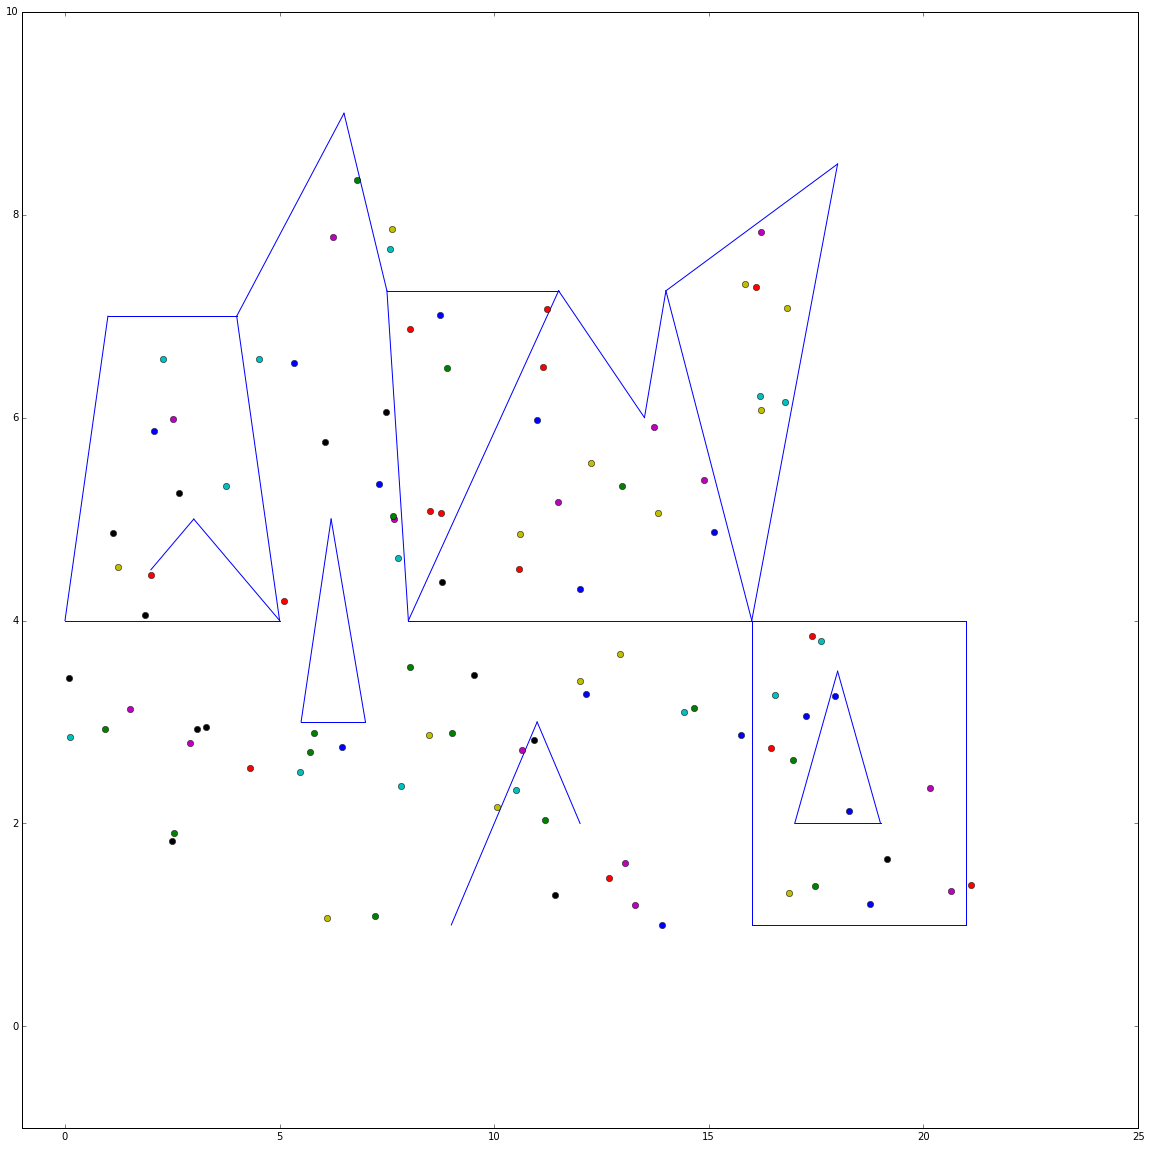

In [88]:
#plotting
figsize(20,20)
network = []
for segment in segments:
    head,tail = segment.vertices
    x1,y1 = head
    x2,y2 = tail
    network.append((x1,x2))
    network.append((y1,y2))
    network.append('b')
plot(*network)
for i,point in points.iteritems():
    x,y = point
    plot(x,y, 'o')
xlim(-1,25)
ylim(-1,10)

In [89]:
res = snapPointsOnSegments(points, segments)

(-1, 10)

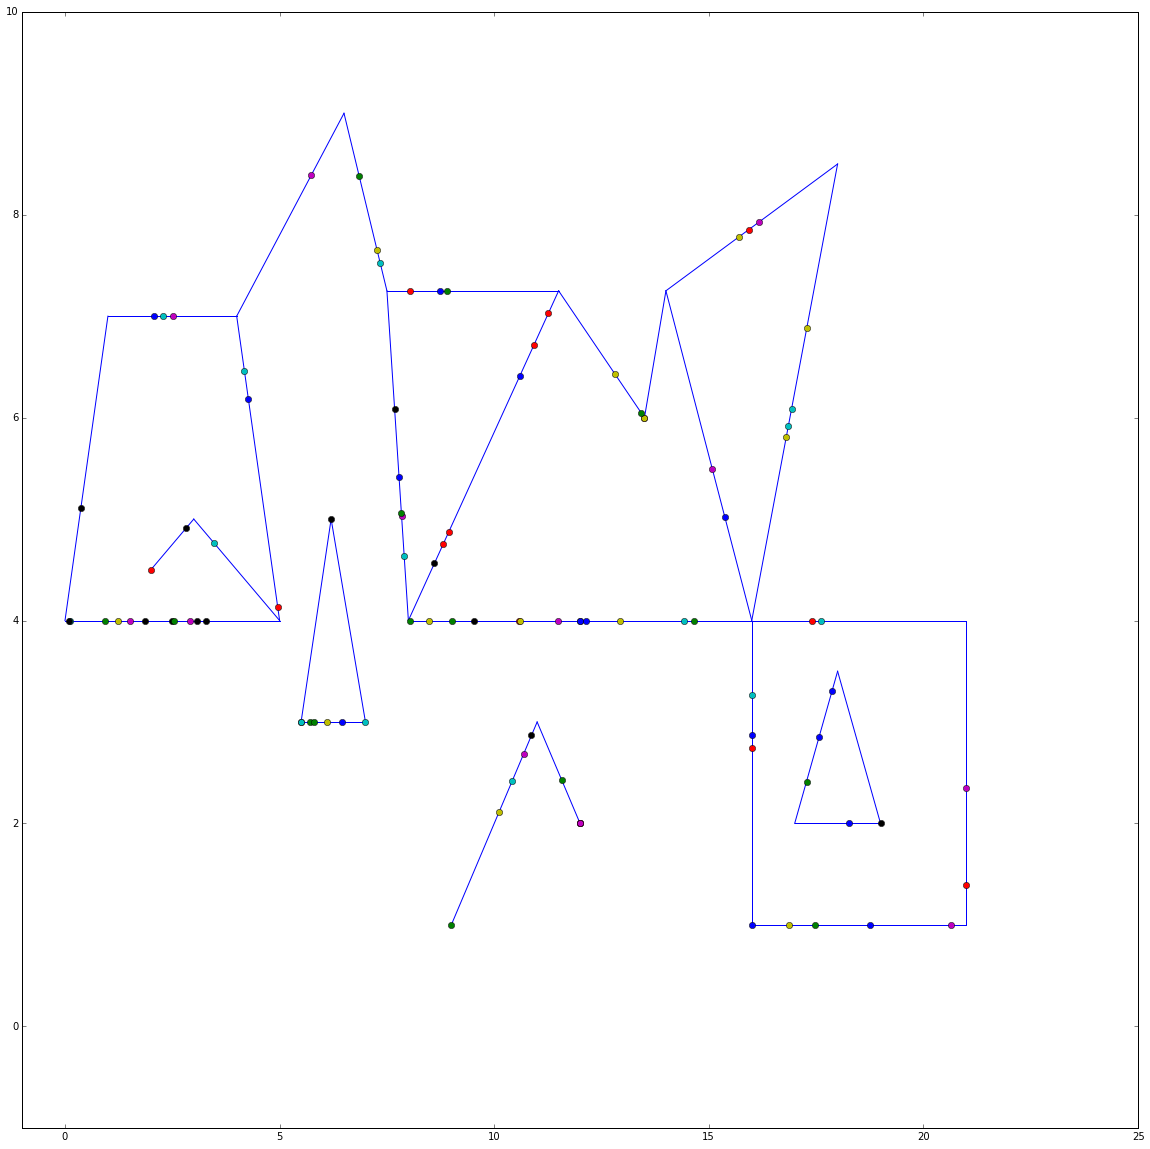

In [91]:
#plotting
figsize(20,20)
network = []
for segment in segments:
    head,tail = segment.vertices
    x1,y1 = head
    x2,y2 = tail
    network.append((x1,x2))
    network.append((y1,y2))
    network.append('b')
plot(*network)
for i,point in points.iteritems():
    snapped = res[i]
    x,y = snapped[1]
    #print point,snapped
    plot(x,y, 'o')
xlim(-1,25)
ylim(-1,10)

In [92]:
pnts = res.keys()
pnts.sort()
for pnt in pnts:
    print pnt, res[pnt]

0 ([(7.5, 7.25), (8.0, 4.0)], array([ 7.78196901,  5.4172014 ]))
1 ([(16.0, 1.0), (21.0, 1.0)], array([ 17.48477286,   1.        ]))
2 ([(7.5, 7.25), (11.5, 7.25)], array([ 8.0312364,  7.25     ]))
3 ([(16.0, 4.0), (21.0, 4.0)], array([ 17.61789534,   4.        ]))
4 ([(11.0, 3.0), (12.0, 2.0)], array([ 12.,   2.]))
5 ([(5.5, 3.0), (7.0, 3.0)], array([ 6.10642267,  3.        ]))
6 ([(11.0, 3.0), (12.0, 2.0)], array([ 12.,   2.]))
7 ([(8.0, 4.0), (11.5, 7.25)], array([ 10.59759848,   6.41205573]))
8 ([(8.0, 4.0), (16.0, 4.0)], array([ 14.65743438,   4.        ]))
9 ([(8.0, 4.0), (16.0, 4.0)], array([ 10.57809675,   4.        ]))
10 ([(8.0, 4.0), (16.0, 4.0)], array([ 14.42771195,   4.        ]))
11 ([(0.0, 4.0), (5.0, 4.0)], array([ 2.92087983,  4.        ]))
12 ([(8.0, 4.0), (16.0, 4.0)], array([ 12.9309289,   4.       ]))
13 ([(0.0, 4.0), (5.0, 4.0)], array([ 2.48996689,  4.        ]))
14 ([(7.5, 7.25), (11.5, 7.25)], array([ 8.7272318,  7.25     ]))
15 ([(9.0, 1.0), (11.0, 3.0)], arr

In [93]:
wvn = ps.open("Waverly.shp")

In [39]:
chains = [ chain for chain in wvn]

In [94]:
bus = ps.open("Fake_Waverly_Bus.shp")
points = {}
for i,pnt in enumerate(bus):
    points[i] = pnt

In [95]:
segments = []
for chain in chains:
    nc = len(chain.vertices)
    for i in range(nc-1):
        segments.append(ps.cg.Chain(chain.vertices[i:i+2]))


In [96]:
chain.vertices[i:i+2]

[(-84.26791, 30.494739), (-84.26803, 30.494906999999998)]

In [97]:
res = snapPointsOnSegments(points, segments)

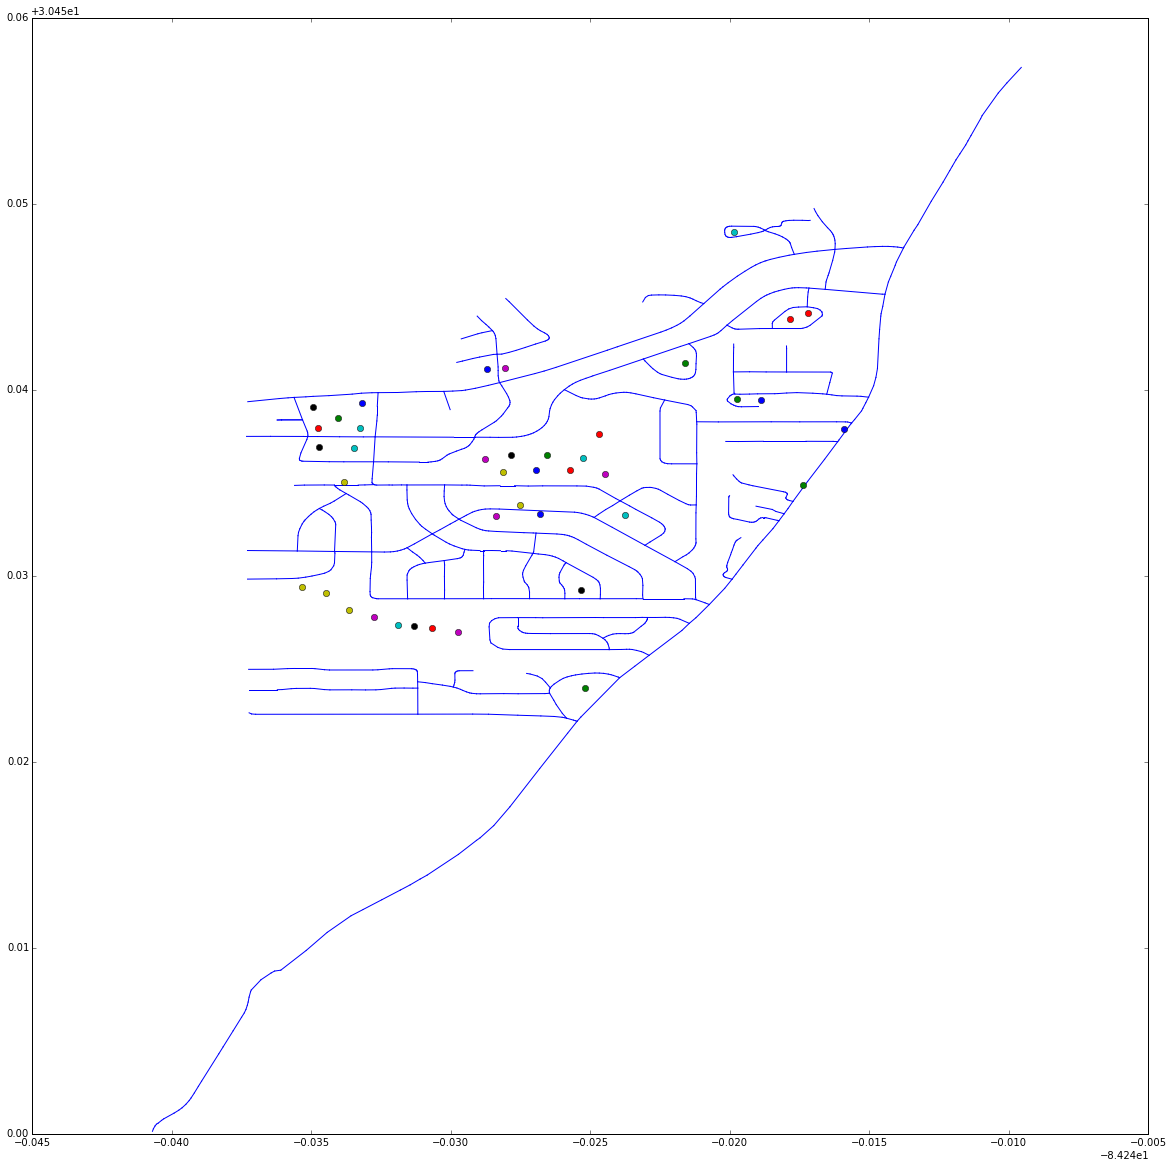

In [98]:
figsize(20,20)
network = []
for segment in segments:
    head,tail = segment.vertices
    x1,y1 = head
    x2,y2 = tail
    network.append((x1,x2))
    network.append((y1,y2))
    network.append('b')
plot(*network)
for i,point in points.iteritems():
    x,y = point
    plot(x,y, 'o')


In [ ]:
#plotting
figsize(20,20)
network = []
for segment in segments:
    head,tail = segment.vertices
    x1,y1 = head
    x2,y2 = tail
    network.append((x1,x2))
    network.append((y1,y2))
    network.append('b')
plot(*network)
for i,point in points.iteritems():
    snapped = res[i]
    x,y = snapped[1]
    #print point,snapped
    plot(x,y, 'o')


In [47]:
for pnt, snapInfo in res.iteritems():
    print pnt, snapInfo

(-84.27495398734, 30.489092763979706) ([(-84.27561999999999, 30.48959), (-84.27531499999999, 30.488384999999997)], array([-84.27546162,  30.48896428]))
(-84.25973443380231, 30.48950941368511) ([(-84.259815, 30.489770999999998), (-84.259637, 30.489760999999998)], array([-84.25972004,  30.48976567]))
(-84.26519094693055, 30.473992594813083) ([(-84.26553099999998, 30.47466999999999), (-84.26530099999998, 30.474719999999998)], array([-84.26534691,  30.47471002]))
(-84.26973985889481, 30.476970147173084) ([(-84.268599, 30.476554), (-84.26862799999999, 30.477254)], array([-84.26861817,  30.47701662]))
(-84.26532187898383, 30.47924410742138) ([(-84.265388, 30.478769999999997), (-84.264646, 30.478766999999998)], array([-84.2653238 ,  30.47876974]))
(-84.26877072841401, 30.486294025728995) ([(-84.26943899999999, 30.486908999999997), (-84.269363, 30.486987)], array([-84.26942093,  30.48692755]))
(-84.26870033420987, 30.491133671005322) ([(-84.268304, 30.491038999999997), (-84.268305, 30.49122999

In [49]:
for k,v in res.iteritems():
    print k, v
    
    

(-84.27495398734, 30.489092763979706) ([(-84.27561999999999, 30.48959), (-84.27531499999999, 30.488384999999997)], array([-84.27546162,  30.48896428]))
(-84.25973443380231, 30.48950941368511) ([(-84.259815, 30.489770999999998), (-84.259637, 30.489760999999998)], array([-84.25972004,  30.48976567]))
(-84.26519094693055, 30.473992594813083) ([(-84.26553099999998, 30.47466999999999), (-84.26530099999998, 30.474719999999998)], array([-84.26534691,  30.47471002]))
(-84.26973985889481, 30.476970147173084) ([(-84.268599, 30.476554), (-84.26862799999999, 30.477254)], array([-84.26861817,  30.47701662]))
(-84.26532187898383, 30.47924410742138) ([(-84.265388, 30.478769999999997), (-84.264646, 30.478766999999998)], array([-84.2653238 ,  30.47876974]))
(-84.26877072841401, 30.486294025728995) ([(-84.26943899999999, 30.486908999999997), (-84.269363, 30.486987)], array([-84.26942093,  30.48692755]))
(-84.26870033420987, 30.491133671005322) ([(-84.268304, 30.491038999999997), (-84.268305, 30.49122999

In [50]:
v


([(-84.25993199999999, 30.498196), (-84.25976299999999, 30.498230999999997)],
 array([-84.25981169,  30.49822092]))

In [51]:
v[-1]


array([-84.25981169,  30.49822092])

In [52]:
x,y = v[-1]

In [53]:
x



-84.259811688512571

In [67]:
def snapping(pointShpFile,lineShpFile):
    shpf = ps.open(lineShpFile)
    segments = []
    for chain in shpf:
        nc = len(chain.vertices)
        for i in range(nc-1):
            segments.append(ps.cg.Chain(chain.vertices[i:i+2]))
    pntf = ps.open(pointShpFile)
    points = []
    for pnt in pntf:
        points.append(pnt)
    return snapPointsOnSegments(points, segments)
    



In [68]:
sf = ps.examples.get_path('geodanet/streets.shp')
pf = ps.examples.get_path('geodanet/crimes.shp')
res = snapping(pf,sf)
 

In [70]:
len(res)

194